# DOE 本番解析用 (base) v4

### ライブラリの一括インポート

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.tse import get_ticker_name_list

### Matplotlib のフォント設定（オプション）

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

### ファイル名から日付を返す関数

In [4]:
# ファイル名から日付を返す関数
def get_date_from_file(file: str) -> pd.Timestamp:
    pattern = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
    if m := pattern.match(file):
        return pd.to_datetime(f"{m.group(1)}-{m.group(2)}-{m.group(3)}")
    else:
        return pd.to_datetime("1970-01-01")

## CSV ファイル一覧の取得

In [5]:
list_doe = [
    "doe-10b",
    "doe-10c",
    "doe-10d",
    "doe-10f",
    "doe-10g",
    "doe-10h",
    "doe-10i",
]  # 0 - 6
name_doe = list_doe[0]  # 実験計画名（フォルダ名）

name_code = "7011"  # 銘柄コード
# name_code = "7203"  # 銘柄コード
# name_code = "8306"  # 銘柄コード
dict_code = get_ticker_name_list([name_code])

# データ読み込み
path_dir = os.path.join("..", "output", name_doe, name_code)
list_file = sorted(os.listdir(path_dir))

print("\n分析対象のシミュレーション・ファイル")
print(list_file)

n_day = len(list_file)
print(f"# of tick files : {n_day}")

# 最後のファイル名から日付文字列を取得して出力するファイル名に付与するための日付文字列を生成
file_last = list_file[-1]
pattern_date = re.compile(r".+_(\d{4})(\d{2})(\d{2})\..+")
if m := pattern_date.match(file_last):
    date_dir = os.path.join(
        "..", "output", name_doe, f"y{m.group(1)}", m.group(2), m.group(3)
    )
    date_str = date_dir
else:
    date_dir = os.path.join("..", "output", name_doe, "y0000", "00", "00")
    date_str = date_dir
os.makedirs(date_dir, exist_ok=True)
print(f"\n日付文字列 : {date_str}")


分析対象のシミュレーション・ファイル
['result_20250819.csv', 'result_20250820.csv', 'result_20250821.csv', 'result_20250822.csv', 'result_20250825.csv', 'result_20250826.csv', 'result_20250827.csv', 'result_20250828.csv', 'result_20250829.csv', 'result_20250901.csv', 'result_20250902.csv', 'result_20250903.csv', 'result_20250904.csv', 'result_20250905.csv', 'result_20250908.csv', 'result_20250909.csv', 'result_20250910.csv', 'result_20250911.csv', 'result_20250912.csv', 'result_20250916.csv', 'result_20250917.csv', 'result_20250918.csv', 'result_20250919.csv', 'result_20250922.csv', 'result_20250924.csv', 'result_20250925.csv', 'result_20250926.csv', 'result_20250929.csv', 'result_20250930.csv', 'result_20251001.csv', 'result_20251002.csv', 'result_20251003.csv', 'result_20251006.csv', 'result_20251007.csv', 'result_20251008.csv', 'result_20251009.csv', 'result_20251010.csv', 'result_20251014.csv', 'result_20251015.csv', 'result_20251016.csv', 'result_20251017.csv', 'result_20251020.csv', 'result_20251

## CSV ファイルの読み込み、連結

In [6]:
list_df = list()
for i, file in enumerate(list_file):
    path_csv = os.path.join(path_dir, file)
    df_tick = pd.read_csv(path_csv)
    df_tick = df_tick.astype({"total": float})
    if i == 0:
        print("\n日毎のシミュレーション結果例（連結前）")
        print(df_tick)
    list_df.append(df_tick)

df = pd.concat(list_df)
df.reset_index(inplace=True, drop=True)
df.to_csv("doe_results.csv", index=False)
print("\n日毎のシミュレーション結果を連結したデータフレーム")
print(df)

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "trade", "total"]
list_col_new = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "損益"]

df_latest = list_df[-1][list_col].copy()
df_latest.columns = list_col_new
df_latest["備考"] = ""
dt_last = get_date_from_file(list_file[-1])
print(f"\n{dt_last.date()} のシミュレーション結果")
print(df_latest)

# HTML 形式で出力
styled = (
    df_latest.style.format({"取引回数": "{:d}", "損益": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_latest_single.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 本日のベスト条件
total_max = df_latest["損益"].max()
df_latest_max = df_latest[df_latest["損益"] == total_max][list_col_new].copy()
df_latest_max.columns = list_col_new
print(f"\n{dt_last.date()} のベスト条件 [{name_doe}]")
print(df_latest_max)


日毎のシミュレーション結果例（連結前）
                    file  code  trade   total  PERIOD_MA_1  PERIOD_MA_2  \
0    ticks_20250819.xlsx  8306     38  2950.0           30          300   
1    ticks_20250819.xlsx  8306     18  1450.0           40          300   
2    ticks_20250819.xlsx  8306     16   500.0           50          300   
3    ticks_20250819.xlsx  8306     10  1000.0           60          300   
4    ticks_20250819.xlsx  8306      6    50.0           70          300   
..                   ...   ...    ...     ...          ...          ...   
284  ticks_20250819.xlsx  8306      2  1400.0          150         1100   
285  ticks_20250819.xlsx  8306      0     0.0          160         1100   
286  ticks_20250819.xlsx  8306      0     0.0          170         1100   
287  ticks_20250819.xlsx  8306      0     0.0          180         1100   
288  ticks_20250819.xlsx  8306      0     0.0          190         1100   

     TURBULENCE  
0            45  
1            45  
2            45  
3     

### 本日の条件

In [7]:
x_por = 170
y_por = 500
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
print(df_latest[(df_latest[col_x] == x_por) & (df_latest[col_y] == y_por)])

    PERIOD_MA_1  PERIOD_MA_2  取引回数   損益 備考
82          170          500     2  0.0   


## 最終日のデータだけで作成した等高線図

In [8]:
plt.rcParams["font.size"] = 12
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "損益"
x = df_latest[col_x]
y = df_latest[col_y]
z = df_latest[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

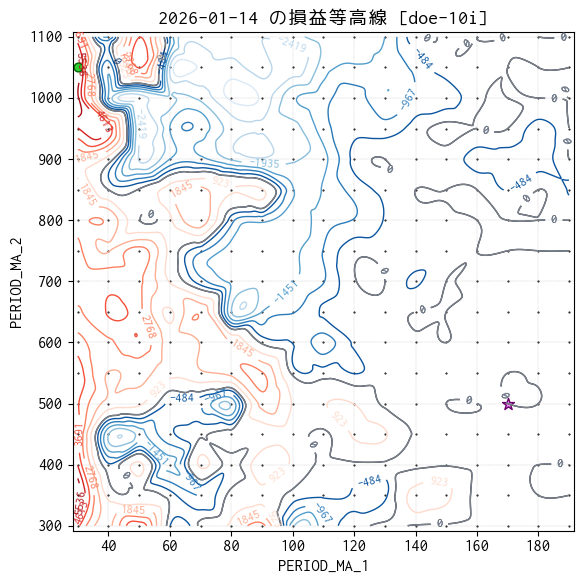

In [9]:
# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# z>0 の等高線（暖色）
levels_pos = np.linspace(0, np.nanmax(Zi), 8)
cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)

# z<0 の等高線（寒色）
levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)

# z=0 の等高線（黒）
cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)

# ラベル
ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.scatter(
    df_latest_max[col_x],
    df_latest_max[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)
ax.scatter(
    x_por,
    y_por,
    marker="*",
    facecolor="#f8f",
    edgecolor="#606",
    s=80,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title(f"{dt_last.date()} の損益等高線 [{name_doe}]")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

output = os.path.join(date_str, f"{name_code}_contour_single.png")

# plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
# plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

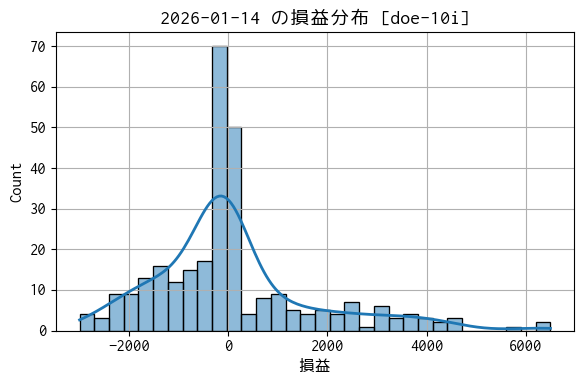

In [10]:
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

sns.histplot(
    data=df_latest,
    x="損益",
    kde=True,
    line_kws={"linewidth": 2},
    ax=ax,
)
ax.grid()
ax.set_title(f"{dt_last.date()} の損益分布 [{name_doe}]")

plt.tight_layout()
output = os.path.join(date_str, f"{name_code}_hist_single.png")
plt.savefig(output)
plt.show()

## 最大・最小損益（ヒストリカル）

In [11]:
total_max = df["total"].max()
total_min = df["total"].min()
print("最高損益")
print(df[df["total"] == total_max])
print("\n最低損益")
print(df[df["total"] == total_min])

最高損益
                     file  code  trade   total  PERIOD_MA_1  PERIOD_MA_2  \
9520  ticks_20251006.xlsx  8306     42  7650.0           30         1100   

      TURBULENCE  
9520          45  

最低損益
                     file  code  trade   total  PERIOD_MA_1  PERIOD_MA_2  \
4301  ticks_20250908.xlsx  8306     52 -5250.0           30         1050   

      TURBULENCE  
4301          45  


## サマリ統計の算出

In [12]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["trade", "total"]

# 因子ごとに応答の平均を集計（サマリデータ）
df_summary = df.groupby(factor_cols)[response_cols].mean().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary = df_summary.sort_values(["PERIOD_MA_2", "PERIOD_MA_1"], ignore_index=True)
print("サマリ統計")
print(df_summary)

# HTML 形式で出力
styled = (
    df_summary.style.format({"trade": "{:.0f}", "total": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)

html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_summary.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

サマリ統計
     PERIOD_MA_1  PERIOD_MA_2      trade       total
0             30          300  44.367347  -52.040816
1             40          300  27.693878  -77.040816
2             50          300  18.469388  105.102041
3             60          300  12.918367   70.408163
4             70          300   9.571429   15.306122
..           ...          ...        ...         ...
284          150         1100   1.387755   40.306122
285          160         1100   1.163265  -55.612245
286          170         1100   1.000000  -34.183673
287          180         1100   0.877551  -83.673469
288          190         1100   0.877551  -68.877551

[289 rows x 4 columns]


## 日付 × 条件 で損益を集計

In [13]:
target = "total"
list_ser = list()

# 行 - 日付、列 - 実験条件 で収益を整理
for i, file in enumerate(list_file):
    date_str_idx = get_date_from_file(file)
    ser = pd.read_csv(os.path.join(path_dir, file))[target]
    # pd.Series の name に日付を設定
    ser.name = date_str_idx
    list_ser.append(ser)
# pd.Series を結合して転置
df_raw = pd.concat(list_ser, axis=1).T
print("\ndf_raw: 日付 x 条件で損益")
df_raw = df_raw.astype("float64")
print(df_raw)


df_raw: 日付 x 条件で損益
               0       1       2       3       4       5       6       7    \
2025-08-19  2950.0  1450.0   500.0  1000.0    50.0   350.0   350.0   350.0   
2025-08-20  -200.0  2700.0  3200.0  3350.0  2800.0  2750.0  1100.0  1350.0   
2025-08-21   150.0  1150.0  1450.0   100.0   100.0   900.0   800.0   800.0   
2025-08-22  2050.0   250.0   500.0   800.0   950.0   100.0  -200.0  -100.0   
2025-08-25  -100.0   200.0   550.0   100.0   350.0   100.0    50.0   200.0   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2026-01-07  1150.0  1150.0  1700.0  1850.0  1750.0  1750.0  1850.0  1800.0   
2026-01-08   200.0  1450.0   500.0   800.0   350.0  1200.0   700.0  1350.0   
2026-01-09  1100.0  1650.0  1800.0  1050.0   800.0   -50.0   300.0     0.0   
2026-01-13   200.0  1850.0  1400.0  1300.0   500.0   750.0   850.0  1000.0   
2026-01-14  3950.0  1550.0  4450.0  -450.0   150.0  1200.0  3100.0 -1800.0   

               8       9    ...     279    

## 平均損益の算出

In [14]:
df_mean = df_raw.copy()
# データスコープを示す文字列
dt_start = df_mean.index[0]
dt_end = df_mean.index[-1]
title_scope = f"{dict_code[name_code]} ({name_code}) from {dt_start.date()} to {dt_end.date()}, n = {n_day} days"
print("データスコープを示す文字列")
print(title_scope)

# 平均収益の算出
n = len(df_mean.index)
while n > 0:
    # 最下行から順に平均値を算出して、行の内容を置換。
    df_mean.iloc[n - 1] = df_mean[:n].mean()
    n -= 1
print("\ndf_mean: 新しい日付から古い日付と逆順に平均損益を算出")
print(df_mean)

# 最終日の平均収益のランキング
ser_ranking = df_mean.iloc[len(df_mean) - 1].sort_values(ascending=False)
print("最新の平均損益（逆ソート後）")
print(ser_ranking)

データスコープを示す文字列
三菱ＵＦＪフィナンシャル・グループ (8306) from 2025-08-19 to 2026-01-14, n = 98 days

df_mean: 新しい日付から古い日付と逆順に平均損益を算出
                    0            1            2            3            4    \
2025-08-19  2950.000000  1450.000000   500.000000  1000.000000    50.000000   
2025-08-20  1375.000000  2075.000000  1850.000000  2175.000000  1425.000000   
2025-08-21   966.666667  1766.666667  1716.666667  1483.333333   983.333333   
2025-08-22  1237.500000  1387.500000  1412.500000  1312.500000   975.000000   
2025-08-25   970.000000  1150.000000  1240.000000  1070.000000   850.000000   
...                 ...          ...          ...          ...          ...   
2026-01-07  -112.234043  -149.468085    22.872340    44.680851    -3.191489   
2026-01-08  -108.947368  -132.631579    27.894737    52.631579     0.526316   
2026-01-09   -96.354167  -114.062500    46.354167    63.020833     8.854167   
2026-01-13   -93.298969   -93.814433    60.309278    75.773196    13.917526   
2026-01-14   -52

### 検算

In [15]:
"""
サマリ統計 (df_summary) の平均値と、算出した平均損益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary["total"] - df_mean.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## 今日（最終データ）のベスト損益

In [16]:
dt_last = df_raw.index[-1]
df_raw_last = df_raw.loc[str(dt_last.date())]
total_last_max = df_raw_last.max()
colname_last_best = df_raw_last[df_raw_last == total_last_max].index[0]

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "total"]
df_last_max = pd.DataFrame(df_summary.loc[colname_last_best][list_col]).T.copy()
df_last_max.loc[colname_last_best, "total"] = total_last_max
list_col_new = ["PERIOD_MA_1", "PERIOD_MA_2", "損益"]
df_last_max.columns = list_col_new
print(f"最終日 ({dt_last.date()}) の最高損益条件")
print(df_last_max)

最終日 (2026-01-14) の最高損益条件
     PERIOD_MA_1  PERIOD_MA_2      損益
255         30.0       1050.0  6500.0


## ランキング

In [17]:
# トップランキング
n_top = 5
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary.iloc[best_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "平均損益"]
df_best.columns = list_col

print("---\n[Best Conditions]")
print(df_best)


# HTML 形式で出力
styled = (
    df_best.style.format({"取引回数": "{:.0f}", "平均損益": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_best.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新のメジアン収益が負になっている実験条件
negative_conditions = ser_ranking[ser_ranking < 0].index
df_negative = df_summary.iloc[negative_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "平均損益"]
df_negative.columns = list_col

print("---\n[Bad Conditions]")
print(df_negative)

---
[Best Conditions]
     PERIOD_MA_1  PERIOD_MA_2       取引回数        平均損益
102           30          600  34.408163  313.775510
104           50          600  14.551020  266.836735
103           40          600  21.428571  266.836735
85            30          550  35.714286  264.795918
274           50         1100  11.510204  263.775510
---
[Bad Conditions]
     PERIOD_MA_1  PERIOD_MA_2       取引回数        平均損益
203          190          850   0.877551   -0.510204
268          160         1050   1.244898   -1.530612
21            70          350   9.142857   -3.571429
84           190          500   0.775510   -4.591837
9            120          300   2.285714   -5.612245
67           190          450   0.755102   -6.632653
230          120          950   2.081633   -7.653061
32           180          350   0.734694   -8.163265
55            70          450   8.102041   -8.163265
219          180          900   0.938776  -10.714286
134          180          650   0.877551  -11.734694
39 

## 実験条件毎の損益トレンド

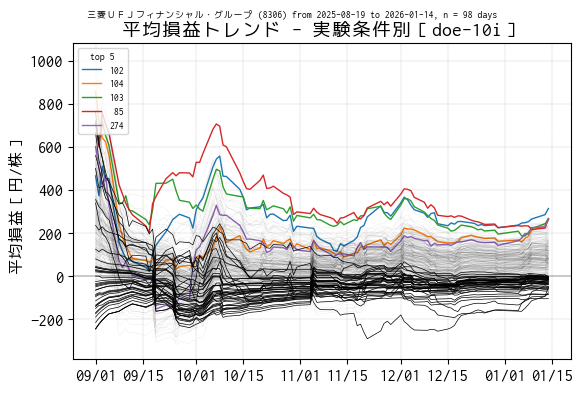

In [18]:
# ---------------------------------------------------------
# 実験条件毎の平均損益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_mean[dt_from <= df_mean.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップランキンgだけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_conditions:  # 最新の平均収益が負になっている条件
        ax.plot(df_trend[colname], linewidth=0.5, linestyle="solid", color="black")
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("平均損益［円/株］")
ax.set_title(f"平均損益トレンド - 実験条件別［{name_doe}］")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = os.path.join(date_str, f"{name_code}_trend_mean_profit_{target}.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## トップ損益条件 (mean) の日別損益トレンド

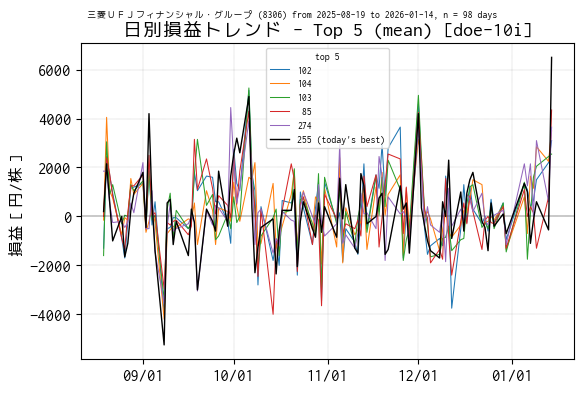

In [19]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))
for colname in best_conditions[:5]:  # トップ 5 だけ
    ax.plot(df_raw[colname], linewidth=0.75, label=f"{colname:3d}")
ax.plot(
    df_raw[colname_last_best],
    color="black",
    linewidth=1.0,
    label=f"{colname_last_best:3d} (today's best)",
)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("損益［円/株］")
ax.set_title(f"日別損益トレンド - Top 5 (mean) [{name_doe}]")
# 凡例
lg = ax.legend(fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})
output = os.path.join(date_str, f"{name_code}_trend_daily_profit_1.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## 生データで等高線図 (Contour Map)

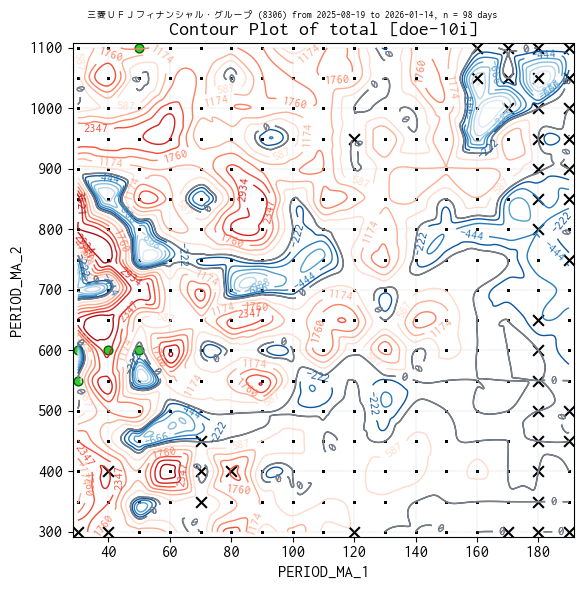

In [20]:
# ---------------------------------------------------------
# 6. グリッドを作成して実データを補完した曲面を描く準備
# ---------------------------------------------------------
col_x = "PERIOD_MA_1"
col_y = "PERIOD_MA_2"
col_z = "total"
x = df[col_x]
y = df[col_y]
z = df[col_z]

# グリッド作成
pitch = 100
dx = (x.max() - x.min()) / pitch
dy = (y.max() - y.min()) / pitch
xi = np.linspace(x.min() - dx, x.max() + dx, pitch * 5)
yi = np.linspace(y.min() - dy, y.max() + dy, pitch * 5)

# 補間
Xi, Yi = np.meshgrid(xi, yi)
Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

# ---------------------------------------------------------
# 5. グラデーション付き等高線（塗りつぶしなし）
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 6))

# Contour Map
# cont = ax.contour(Xi, Yi, Zi, levels=15, cmap="coolwarm", linewidths=1)
# ax.clabel(cont, inline=True, fontsize=9)

# z>0 の等高線（暖色）
levels_pos = np.linspace(0, np.nanmax(Zi), 8)
cont_pos = ax.contour(Xi, Yi, Zi, levels=levels_pos, cmap="Reds", linewidths=1)

# z<0 の等高線（寒色）
levels_neg = np.linspace(np.nanmin(Zi), 0, 8)
cont_neg = ax.contour(Xi, Yi, Zi, levels=levels_neg, cmap="Blues", linewidths=1)

# z=0 の等高線（黒）
cont0 = ax.contour(Xi, Yi, Zi, levels=[0], colors="gray", linewidths=1)

# ラベル
ax.clabel(cont_pos, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont_neg, inline=True, fontsize=9, fmt="%.0f")
ax.clabel(cont0, inline=True, fontsize=9, fmt="0")

ax.set_xlabel(col_x)
ax.set_ylabel(col_y)
ax.set_title(f"Contour Plot of total [{name_doe}]")
ax.grid(True, color="gray", linestyle="dotted", linewidth=0.25)

# 最適点
ax.scatter(
    df_best[col_x],
    df_best[col_y],
    marker="o",
    facecolor="limegreen",
    edgecolor="darkgreen",
    s=40,
    zorder=1,
)

# 最新の平均収益が負になる点
ax.scatter(
    df_negative[col_x],
    df_negative[col_y],
    marker="x",
    color="black",
    s=60,
    zorder=1,
)

# 実験点を黒丸で追加
ax.scatter(x, y, color="black", s=1, marker=".", zorder=0)

plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.925)  # 上の余白だけ調整
output = os.path.join(date_str, f"{name_code}_raw_contour_{target}.png")
plt.savefig(output)
plt.show()

## メディアン損益の算出

In [21]:
df_median = df_raw.copy()
# データスコープを示す文字列
dt_start = df_median.index[0]
dt_end = df_median.index[-1]
title_scope = f"{dict_code[name_code]} ({name_code}) from {dt_start.date()} to {dt_end.date()}, n = {n_day} days"
print("データスコープを示す文字列")
print(title_scope)

データスコープを示す文字列
三菱ＵＦＪフィナンシャル・グループ (8306) from 2025-08-19 to 2026-01-14, n = 98 days


In [22]:
n = len(df_median.index)

In [23]:
df_median[:n].median()

0       25.0
1     -200.0
2       75.0
3       25.0
4        0.0
       ...  
284      0.0
285      0.0
286      0.0
287      0.0
288      0.0
Length: 289, dtype: float64

In [24]:
# メディアン損益の算出
n = len(df_median.index)
while n > 0:
    # 最下行から順にメディアンを算出して、行の内容を置換。
    df_median.iloc[n - 1] = df_median[:n].median()
    n -= 1
print("\ndf_median: 新しい日付から古い日付と逆順にメディアン損益を算出")
print(df_median)

# 最終日の損益収益のランキング
ser_ranking = df_median.iloc[len(df_median) - 1].sort_values(ascending=False)
print("最新のメディアン損益（逆ソート後）")
print(ser_ranking)


df_median: 新しい日付から古い日付と逆順にメディアン損益を算出
               0       1       2       3       4       5      6      7    \
2025-08-19  2950.0  1450.0   500.0  1000.0    50.0   350.0  350.0  350.0   
2025-08-20  1375.0  2075.0  1850.0  2175.0  1425.0  1550.0  725.0  850.0   
2025-08-21   150.0  1450.0  1450.0  1000.0   100.0   900.0  800.0  800.0   
2025-08-22  1100.0  1300.0   975.0   900.0   525.0   625.0  575.0  575.0   
2025-08-25   150.0  1150.0   550.0   800.0   350.0   350.0  350.0  350.0   
...            ...     ...     ...     ...     ...     ...    ...    ...   
2026-01-07   -25.0  -225.0    50.0     0.0     0.0     0.0    0.0    0.0   
2026-01-08     0.0  -200.0    50.0     0.0     0.0     0.0    0.0    0.0   
2026-01-09     0.0  -200.0    50.0    25.0     0.0     0.0    0.0    0.0   
2026-01-13     0.0  -200.0    50.0    50.0     0.0     0.0    0.0    0.0   
2026-01-14    25.0  -200.0    75.0    25.0     0.0     0.0    0.0    0.0   

              8      9    ...    279     280     

## サマリ統計（メディアン）

In [25]:
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2"]
response_cols = ["trade", "total"]

# 因子ごとに応答のメディアンを集計（サマリデータ）
df_summary_2 = df.groupby(factor_cols)[response_cols].median().reset_index()
# ソート（実際の実験順序に合わせる）
df_summary_2 = df_summary_2.sort_values(
    ["PERIOD_MA_2", "PERIOD_MA_1"], ignore_index=True
)
print("サマリ統計（メディアン）")
print(df_summary_2)

サマリ統計（メディアン）
     PERIOD_MA_1  PERIOD_MA_2  trade  total
0             30          300   42.0   25.0
1             40          300   24.0 -200.0
2             50          300   16.0   75.0
3             60          300   10.0   25.0
4             70          300    8.0    0.0
..           ...          ...    ...    ...
284          150         1100    1.0    0.0
285          160         1100    0.0    0.0
286          170         1100    0.0    0.0
287          180         1100    0.0    0.0
288          190         1100    0.0    0.0

[289 rows x 4 columns]


### 検算

In [26]:
"""
サマリ統計 (df_summary) の平均値と、算出したメジアン損益 (df_mean) の
最終日の値が一致していることを、
差分をとって平方和が 0 になることで確認
"""

# 差分の平方和 (SSD, Sum of Squared Differences)
ssd = ((df_summary_2["total"] - df_median.iloc[n - 1]) ** 2).sum()
print(ssd)

0.0


## ランキング (2)

In [27]:
# トップランキング
n_top = 10
best_conditions = list(ser_ranking.index[:n_top])
df_best = df_summary_2.iloc[best_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "メジアン損益"]
df_best.columns = list_col

print("---\n[Best Conditions]")
print(df_best)


# HTML 形式で出力
styled = (
    df_best.style.format({"取引回数": "{:.0f}", "メジアン損益": "{:.1f}"})
    .set_table_styles([{"selector": "td", "props": "text-align: right;"}])
    .set_table_attributes('class="simple"')
)
html = styled.to_html()
output = os.path.join(date_str, f"{name_code}_best_median.html")
with open(output, "w", encoding="utf-8") as f:
    f.write(html)

# 最新のメジアン収益が負になっている実験条件
negative_conditions = ser_ranking[ser_ranking < 0].index
df_negative = df_summary_2.iloc[negative_conditions].copy()

list_col = ["PERIOD_MA_1", "PERIOD_MA_2", "取引回数", "メジアン損益"]
df_negative.columns = list_col

print("---\n[Bad Conditions]")
print(df_negative)

---
[Best Conditions]
     PERIOD_MA_1  PERIOD_MA_2  取引回数  メジアン損益
102           30          600  32.0   375.0
104           50          600  14.0   175.0
170           30          800  30.0   150.0
120           40          650  20.0   125.0
119           30          650  32.0   125.0
85            30          550  34.0   125.0
171           40          800  18.0   125.0
88            60          550   8.0   100.0
154           40          750  18.0   100.0
103           40          600  20.0   100.0
---
[Bad Conditions]
     PERIOD_MA_1  PERIOD_MA_2  取引回数  メジアン損益
240           50         1000  10.0   -25.0
139           60          700   8.0   -25.0
87            50          550  12.0   -25.0
123           70          650   6.0   -25.0
191           70          850   6.0   -50.0
257           50         1050  10.0   -50.0
138           50          700  12.0   -50.0
238           30         1000  26.0   -75.0
121           50          650  12.0   -75.0
17            30          350  38

## 実験条件毎の収益トレンド（メジアン）

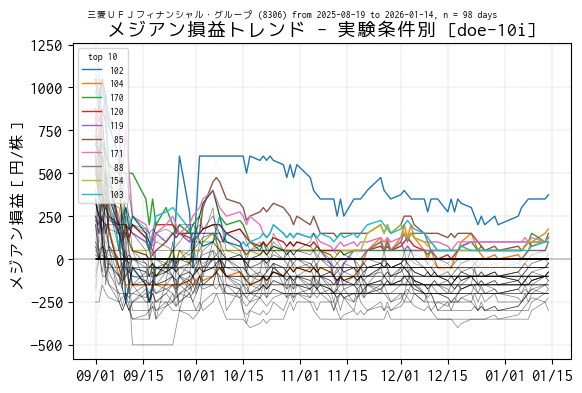

In [28]:
# ---------------------------------------------------------
# 実験条件毎のメジアン損益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))

dt_from = pd.to_datetime("2025-09-01")
df_trend = df_median[dt_from <= df_median.index]

for colname in ser_ranking.index:
    if colname in best_conditions:  # トップ 5 だけ色を付ける
        ax.plot(df_trend[colname], linewidth=1.0, label=f"{colname:3d}")
    elif colname in negative_conditions:  # 最新の平均収益が負になっている条件
        ax.plot(
            df_trend[colname],
            linewidth=0.5,
            linestyle="solid",
            color="black",
            alpha=0.5,
        )
    else:
        ax.plot(df_trend[colname], linewidth=0.25, color="black", alpha=0.1)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("メジアン損益［円/株］")
ax.set_title(f"メジアン損益トレンド - 実験条件別 [{name_doe}]")
# 凡例
lg = ax.legend(loc="upper left", fontsize=7)
lg.set_title(f"top {len(best_conditions)}", prop={"size": 7})

output = os.path.join(date_str, f"{name_code}_trend_median_profit_{target}.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()

## トップ収益条件 (median) の日別損益トレンド

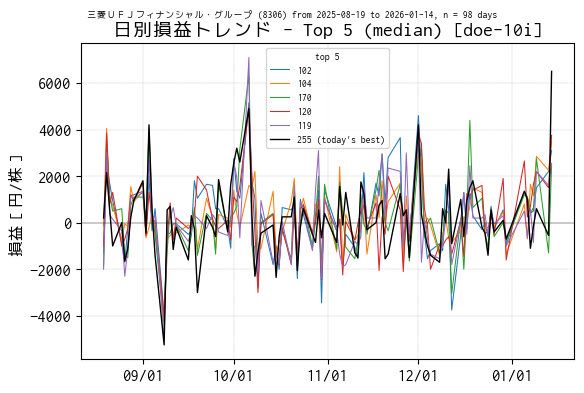

In [29]:
# ---------------------------------------------------------
# 実験条件毎の平均収益トレンド
# ---------------------------------------------------------
plt.rcParams["font.size"] = 12
fig, ax = plt.subplots(figsize=(6, 4))
for colname in best_conditions[:5]:  # トップ 5 だけ
    ax.plot(df_raw[colname], linewidth=0.75, label=f"{colname:3d}")
ax.plot(
    df_raw[colname_last_best],
    color="black",
    linewidth=1.0,
    label=f"{colname_last_best:3d} (today's best)",
)

ax.axhline(y=0, color="black", linewidth=0.25)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d"))
ax.grid(True, color="black", linestyle="dotted", linewidth=0.25, alpha=0.6)
ax.set_ylabel("損益［円/株］")
ax.set_title(f"日別損益トレンド - Top 5 (median) [{name_doe}]")
# 凡例
lg = ax.legend(fontsize=7)
lg.set_title("top 5", prop={"size": 7})
output = os.path.join(date_str, f"{name_code}_trend_daily_profit_2.png")
plt.suptitle(title_scope, fontsize=7)
plt.tight_layout()
plt.subplots_adjust(top=0.895)  # 上の余白だけ調整
plt.savefig(output)
plt.show()